In [1]:
# Code taken from https://github.com/LAION-AI/aesthetic-predictor
import os
import torch
import sys
import random

sys.path.append('..')

from src.datasets.newsimages import NewsImageDataset

import torch.nn as nn
from os.path import expanduser  # pylint: disable=import-outside-toplevel
from urllib.request import urlretrieve  # pylint: disable=import-outside-toplevel
def get_aesthetic_model(clip_model="vit_l_14"):
    """load the aethetic model"""
    home = expanduser("~")
    cache_folder = home + "/.cache/emb_reader"
    path_to_model = cache_folder + "/sa_0_4_"+clip_model+"_linear.pth"
    if not os.path.exists(path_to_model):
        os.makedirs(cache_folder, exist_ok=True)
        url_model = (
            "https://github.com/LAION-AI/aesthetic-predictor/blob/main/sa_0_4_"+clip_model+"_linear.pth?raw=true"
        )
        urlretrieve(url_model, path_to_model)
    if clip_model == "vit_l_14":
        m = nn.Linear(768, 1)
    elif clip_model == "vit_b_32":
        m = nn.Linear(512, 1)
    else:
        raise ValueError()
    s = torch.load(path_to_model)
    m.load_state_dict(s)
    m.eval()
    return m

In [2]:
CSV_PATH = '../data/newsimages/newsimages_25_v1.0/newsarticles.csv'
IMAGE_PATH = '../data/newsimages/newsimages_25_v1.0/newsimages/'

In [3]:
news_image_dataset = NewsImageDataset(IMAGE_PATH, CSV_PATH)

In [5]:
aesthetics_model = get_aesthetic_model()

In [6]:
type(news_image_dataset[0]['image'])

PIL.Image.Image

In [2]:
import open_clip

/home/aash/MLProjects/newsimages_um_rtl/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [105]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')

/home/aash/MLProjects/newsimages_um_rtl/venv/lib/python3.12/site-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


In [11]:
image = preprocess(news_image_dataset[1]['image']).unsqueeze(0)

In [106]:
model.to('cuda:1')
aesthetics_model.to('cuda:1')

Linear(in_features=768, out_features=1, bias=True)

In [110]:
aesthetics_distribution = {}
for i in range(len(news_image_dataset)):
    title = news_image_dataset[i]['title']
    image = preprocess(news_image_dataset[i]['image']).unsqueeze(0)
    with torch.no_grad():
        image_features = model.encode_image(image.to("cuda:1"))
        image_features /= image_features.norm(dim=-1, keepdim=True)
        prediction = aesthetics_model(image_features).detach().cpu().item()
    aesthetics_distribution[i] = prediction
all_aesthetic_scores = [aesthetics_distribution[key] for key in list(aesthetics_distribution.keys())]

In [111]:
len(all_aesthetic_scores)

8500

In [ ]:
from abc import ABC
import abstract

In [ ]:
class Reranking(ABC):
    """
    Abstract class for reranking.

    Reranking inputs are sorted indices, similarity scores, and other features depending on the algorithm.
    Returns tuples of two arrays: 
    - reranked indices matrix, shape: [num_queries, num_candidates]
    - updated similarity scores, shape: [num_queries, num_candidates]
    """

    @abstractmethod
    def rerank(self, *args, **kwargs) -> Tuple[ArrayLike, ArrayLike]:
        pass

In [ ]:
class AestheticsReranking(Reranking):

    def __init__(self,aesthetic_model:torch.nn.Module,device:torch.device,weight_reranking:int  = 0.1):
        self.aesthetic_model = aesthetic_model
        self.device = device 
        self.weight_reranking = weight_reranking

    def rerank(self,sorted_indices,similarity_scores,top_k_image_paths,**kwargs):
        # Similarity score is likely a torch array
        aesthetic_scores = self.return_aesthetic_scores(sorted_indices,top_k_image_paths)
        similarity_rank = torch.argsort(similarity_scores,dim=1,descending = True)
        aesthetic_rank = torch.stack(aesthetic_scores)
        final_ranking = AestheticsReranking.borda_count(similarity_rank,aesthetic_rank,self.weight_reranking)
        return final_ranking, similarity_scores



    #TODO: Check if this code runs as intendid
    def return_aesthetic_scores(self,sorted_indices,top_k_image_paths):
        """sorted_indices: the indices which are the top predictions
        the function returns list of tensors: aesthetic_scores 
        """
        num_queries = top_k_image_paths.shape[0]
        num_candidates = top_k_image_paths.shape[1]
        self.aesthetic_model.eval()
        aesthetic_scores =[]
        for query in range(num_queries):
            images = [Image.open(image) for image in top_k_image_paths[query]]
            prediction = self.aesthetic_model(prediction)
            aesthetic_scores.append(prediction)
        return aesthetic_scores
    
    @staticmethod
    #TODO: Check if this code runs as intendid 
    def borda_count(ranked_array_1,ranked_array_2,weight):
        """ ranked_array_1: a ranked list 
            ranked_array_2 : a ranked list 
        """
        weighted_scores = [weight,1-weight] 
        weighted_scores = ranked_array_1*weighted_scores[0]+ranked_array_2*weighted_scores[1]
        print(weighted_scores)
        return torch.argsort(weighted_scores,dim=1,descending=True)
            




NameError: name 'Reranking' is not defined

In [8]:
class AestheticModel(nn.Module):
    def __init__(self,device='cpu'):
        super().__init__()
        self.forward_model = AestheticModel.get_aesthetic_model()
        self.clip_model,_,self.preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')
        self.clip_model.eval()
        self.device = device 
        self.clip_model.to(device)
        self.forward_model.to(device)
    def forward(self,images:list):
        images = [self.preprocess(image) for image in images]
        with torch.no_grad():
            image_features = self.clip_model.encode_image(torch.stack(images).to(self.device))
            print(image_features.shape)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            print(image_features.shape)
            prediction = self.forward_model(image_features).detach().squeeze().to('cpu')
        return prediction
            
    @staticmethod
    def get_aesthetic_model(clip_model="vit_l_14"):
        """load the aethetic model"""
        home = expanduser("~")
        cache_folder = home + "/.cache/emb_reader"
        path_to_model = cache_folder + "/sa_0_4_"+clip_model+"_linear.pth"
        if not os.path.exists(path_to_model):
            os.makedirs(cache_folder, exist_ok=True)
            url_model = (
                "https://github.com/LAION-AI/aesthetic-predictor/blob/main/sa_0_4_"+clip_model+"_linear.pth?raw=true"
            )
            urlretrieve(url_model, path_to_model)
        if clip_model == "vit_l_14":
            m = nn.Linear(768, 1)
        elif clip_model == "vit_b_32":
            m = nn.Linear(512, 1)
        else:
            raise ValueError()
        s = torch.load(path_to_model)
        m.load_state_dict(s)
        m.eval()
        return m

In [9]:
aesthetic_model = AestheticModel('cuda:1')

/home/aash/MLProjects/newsimages_um_rtl/venv/lib/python3.12/site-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


In [10]:
from PIL import Image

In [11]:
image_dir = [Image.open(os.path.join('../data/newsimages/newsimages_25_v1.0/newsimages',pathing)) for pathing in  os.listdir('../data/newsimages/newsimages_25_v1.0/newsimages')[:10]]

In [15]:
stack_preds = []
for i in range(2):
    prediction = aesthetic_model.forward(image_dir)
    stack_preds.append(prediction)

torch.Size([10, 768])
torch.Size([10, 768])
torch.Size([10, 768])
torch.Size([10, 768])


In [18]:
aesthetic_scores = torch.stack(stack_preds)

In [52]:
aesthetic_scores

tensor([[4.0524, 4.0308, 5.7242, 3.8702, 4.4843, 5.7661, 5.4494, 5.0377, 4.4887,
         5.2163],
        [4.0524, 4.0308, 5.7242, 3.8702, 4.4843, 5.7661, 5.4494, 5.0377, 4.4887,
         5.2163]])

In [32]:
ranks = torch.argsort(aesthetic_scores,dim=1,descending=False)

In [58]:
len(ranks[0])

10

In [123]:
ranks

tensor([[3, 1, 0, 4, 8, 7, 9, 6, 2, 5],
        [3, 1, 0, 4, 8, 7, 9, 6, 2, 5]])

In [125]:
((10-(ranks+1)))

tensor([[6, 8, 9, 5, 1, 2, 0, 3, 7, 4],
        [6, 8, 9, 5, 1, 2, 0, 3, 7, 4]])

In [122]:
torch.argsort(ranks,dim=1, descending=False)

tensor([[2, 1, 8, 0, 3, 9, 7, 5, 4, 6],
        [2, 1, 8, 0, 3, 9, 7, 5, 4, 6]])

In [126]:
rerank = len(ranks[0]) - (ranks+1)

In [128]:
rerank.argsort(dim=1,descending=True)

tensor([[2, 1, 8, 0, 3, 9, 7, 5, 4, 6],
        [2, 1, 8, 0, 3, 9, 7, 5, 4, 6]])

In [108]:
def borda_count(ranked_array_1,ranked_array_2,weight):
        """ ranked_array_1: a ranked list 
            ranked_array_2 : a ranked list 
        """
        ranked_array_1 = len(ranked_array_1[0])-(ranked_array_1+1)
        print(ranked_array_1)
        ranked_array_2 = len(ranked_array_2[0])-(ranked_array_2+1)
        weighted_scores = [weight,1-weight] 
        weighted_scores = ranked_array_1*weighted_scores[0]+ranked_array_2*weighted_scores[1]
        print(weighted_scores)
        return torch.argsort(-weighted_scores,dim=1)

In [91]:
import numpy as np

In [92]:
dir_list = np.array(os.listdir('../data/newsimages/newsimages_25_v1.0/newsimages')[:10])

In [94]:
initial_rank = dir_list[ranks[0]]

In [114]:
final_rankings

tensor([[2, 1, 8, 0, 3, 9, 7, 5, 4, 6],
        [2, 1, 8, 0, 3, 9, 7, 5, 4, 6]])

In [ ]:
dir_list[ranks[0]]

In [109]:
final_rankings = borda_count(ranks,ranks,0.5)

tensor([[6, 8, 9, 5, 1, 2, 0, 3, 7, 4],
        [6, 8, 9, 5, 1, 2, 0, 3, 7, 4]])
tensor([[6., 8., 9., 5., 1., 2., 0., 3., 7., 4.],
        [6., 8., 9., 5., 1., 2., 0., 3., 7., 4.]])


In [83]:
final_rankings

tensor([[6, 4, 5, 7, 9, 3, 0, 8, 1, 2],
        [6, 4, 5, 7, 9, 3, 0, 8, 1, 2]])

In [69]:
reranked_list = [rank[rerank] for rank,rerank in zip(ranks,final_rankings)]

In [ ]:
image_dir = np.array(image_dir)

RuntimeError: Could not infer dtype of JpegImageFile

In [70]:
reranked_list

[tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]

5.817824363708496
Israelis march on Jerusalem to protest judicial overhaul


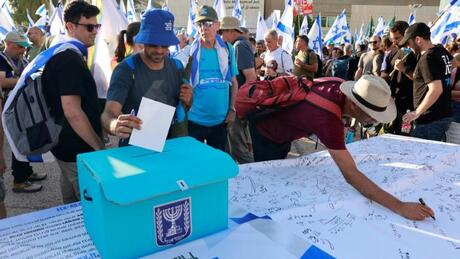

In [112]:
idx = 450
print(all_aesthetic_scores[idx])
print(news_image_dataset[idx]['title'])
news_image_dataset[idx]['image']

Text(0, 0.5, 'Frequency')

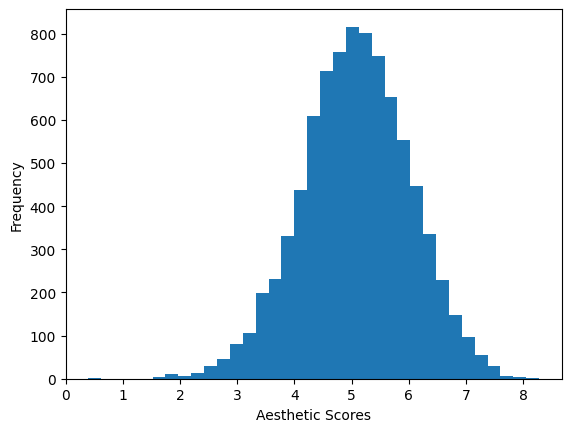

In [113]:
import matplotlib.pyplot as plt

plt.hist(x=all_aesthetic_scores,bins =35)
plt.xlabel('Aesthetic Scores')
plt.ylabel('Frequency')

In [116]:
random_indices = random.sample(range(len(news_image_dataset)), 4)

6.118007659912109
3.6153011322021484
6.323183059692383
5.573912143707275


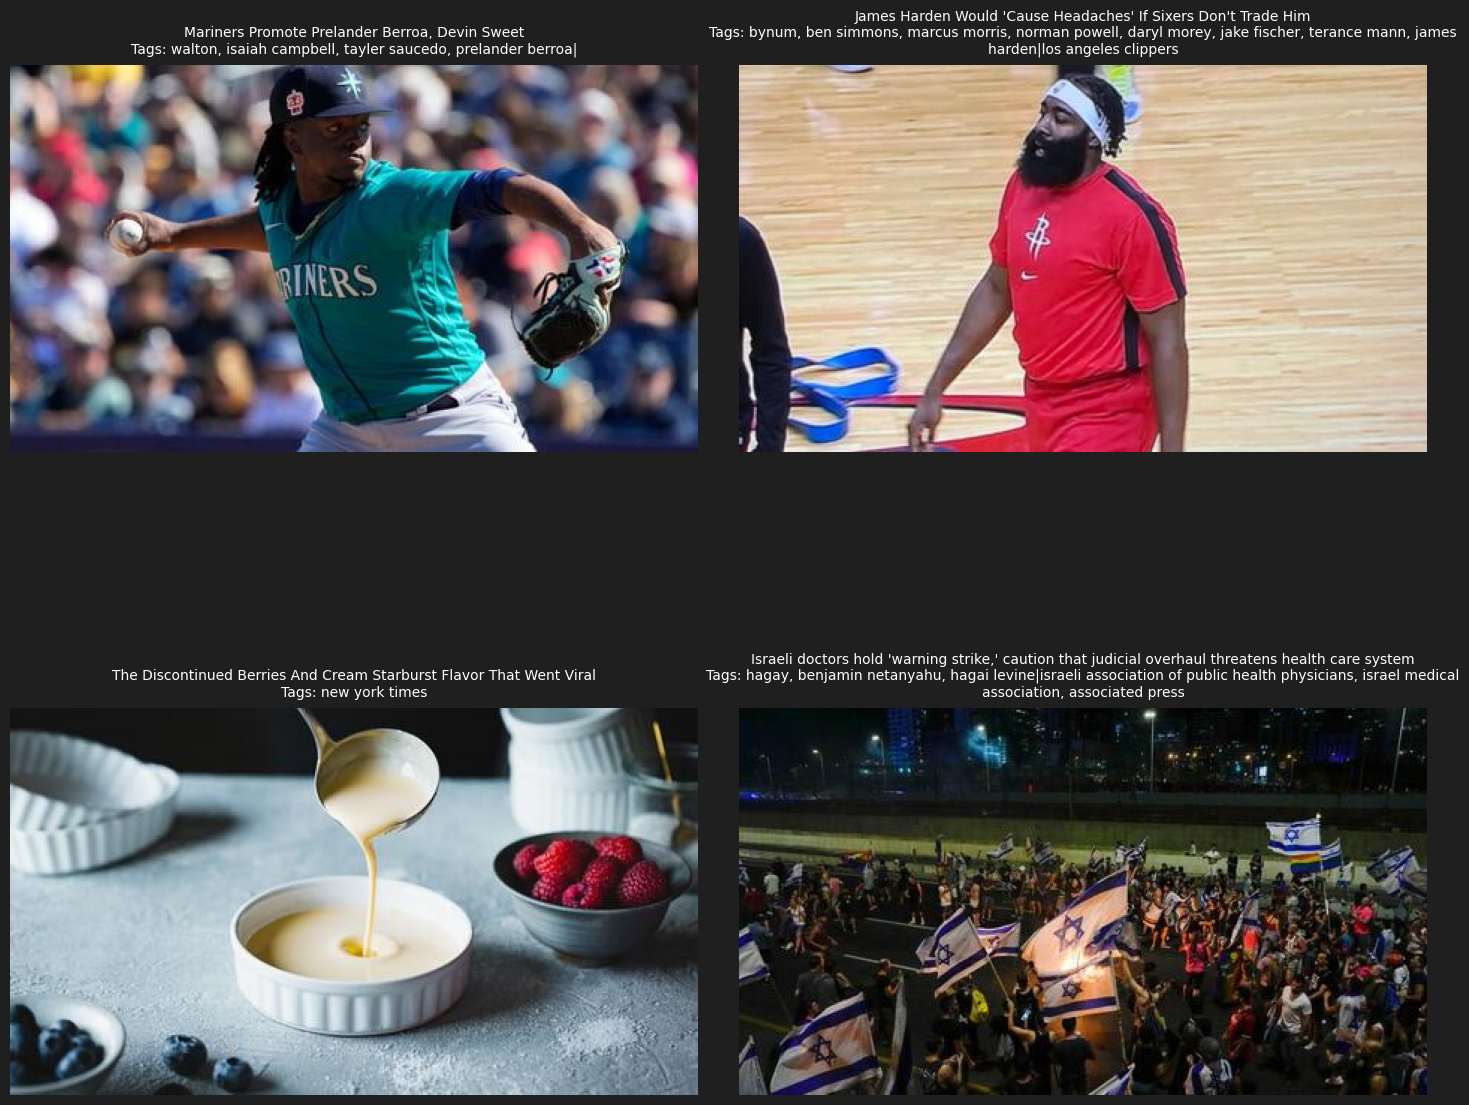

In [117]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()
fig.patch.set_facecolor('#1f1f1f')

random_indices = random.sample(range(len(news_image_dataset)), 4)

for i, idx in enumerate(random_indices):
    sample = news_image_dataset[idx]
    ax = axes[i]
    
    ax.imshow(sample['image'])
    print(all_aesthetic_scores[idx])
    title = sample['title']
    
    if 'tags' in sample:
        tags_text = '\nTags: ' + ', '.join(sample['tags'])
        title += tags_text
    
    ax.set_title(title, pad=10, wrap=True, fontsize=10, color='white')
    ax.axis('off')

plt.tight_layout(pad=3.0)
plt.show()

In [120]:
import transformers 
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("Babelscape/wikineural-multilingual-ner")
model = AutoModelForTokenClassification.from_pretrained("Babelscape/wikineural-multilingual-ner")


In [121]:
nlp = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True)

Device set to use cuda:0
/home/aash/MLProjects/newsimages_um_rtl/venv/lib/python3.12/site-packages/transformers/pipelines/token_classification.py:181: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


In [177]:
random_number = random.randint(0,len(news_image_dataset))
example = news_image_dataset[random_number]['title']
ner_results = nlp(example)
print(example)
print(ner_results)
print(all_aesthetic_scores[random_number])

The Little Rascals cast: Where are they now?
[{'entity_group': 'MISC', 'score': np.float32(0.6319654), 'word': 'Little Rascals', 'start': 4, 'end': 18}]
6.522509574890137


In [145]:
ner_results[1]['entity_group']

IndexError: list index out of range

In [178]:
all_entities_persons_idx = []
all_entities_org_idx = []
all_entities_loc_idx = []
all_entities_misc_idx = []
all_no_entities = []
all_entities = []
for i,news_article in enumerate(news_image_dataset):
    recognized_ners = nlp(news_article['title'])
    classses_per_index = [recognized_ner['entity_group'] for recognized_ner in recognized_ners]
    if 'ORG' in classses_per_index:
        all_entities_org_idx.append(i)
    if 'LOC' in classses_per_index:
        all_entities_loc_idx.append(i)
    if 'PER' in classses_per_index:
        all_entities_persons_idx.append(i)
    if 'MISC' in classses_per_index:
        all_entities_misc_idx.append(i)
    if not classses_per_index:
        all_no_entities.append(idx)
    all_entities.append(classses_per_index)


In [100]:
len(news_image_dataset)

8500

In [102]:
len(all_aesthetic_scores)

8158

In [74]:
import numpy as np

In [133]:
all_aesthetic_scores = np.array(all_aesthetic_scores)

In [88]:
np.array(all_entities_org_idx).shape

(2851,)

In [91]:
all_aesthetic_scores[[0,1]]

array([4.05991459, 6.01127148])

Text(5.3011274049608685, 599.1300000000001, 'Mean: 5.30')

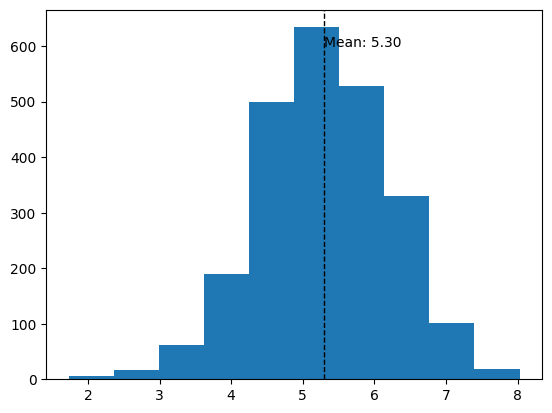

In [179]:
plt.hist(all_aesthetic_scores[all_entities_persons_idx])
plt.axvline(all_aesthetic_scores[all_entities_persons_idx].mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(all_aesthetic_scores[all_entities_persons_idx].mean(),max_ylim*0.9, 'Mean: {:.2f}'.format(all_aesthetic_scores[all_entities_persons_idx].mean()))

Text(5.01369544883427, 1125.495, 'Mean: 5.01')

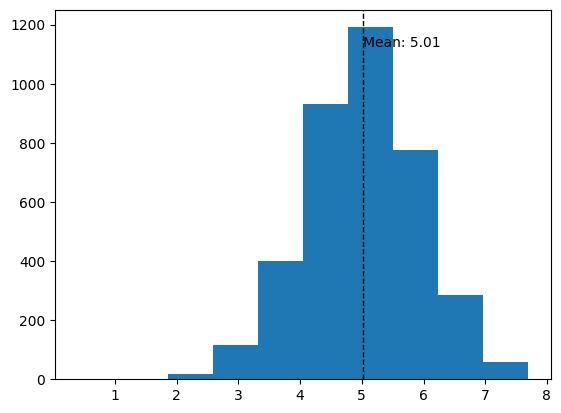

In [141]:
plt.hist(all_aesthetic_scores[all_entities_loc_idx])
plt.axvline(all_aesthetic_scores[all_entities_loc_idx].mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(all_aesthetic_scores[all_entities_loc_idx].mean(),max_ylim*0.9, 'Mean: {:.2f}'.format(all_aesthetic_scores[all_entities_loc_idx].mean()))

Text(5.056088632050417, 789.075, 'Mean: 5.06')

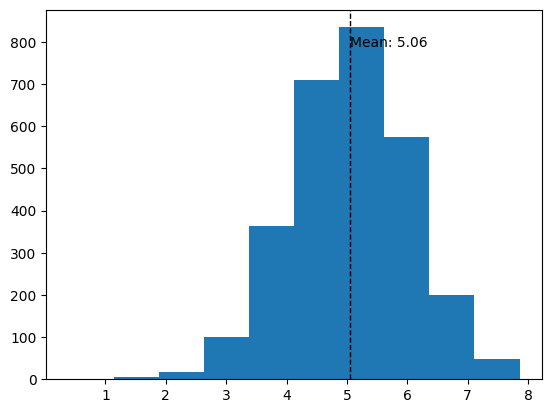

In [142]:
plt.hist(all_aesthetic_scores[all_entities_org_idx])
plt.axvline(all_aesthetic_scores[all_entities_org_idx].mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(all_aesthetic_scores[all_entities_org_idx].mean(),max_ylim*0.9, 'Mean: {:.2f}'.format(all_aesthetic_scores[all_entities_org_idx].mean()))

Text(5.096613828038824, 841.0500000000001, 'Mean: 5.10')

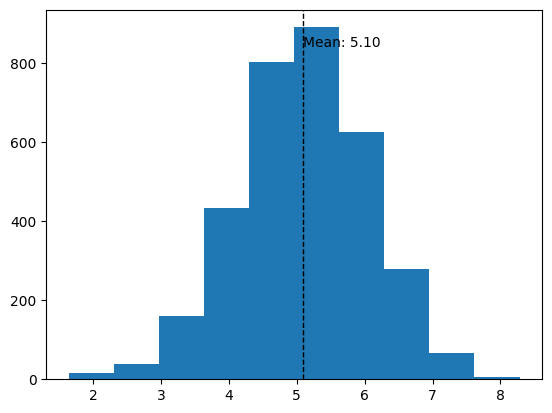

In [181]:
plt.hist(all_aesthetic_scores[all_entities_misc_idx])
plt.axvline(all_aesthetic_scores[all_entities_misc_idx].mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(all_aesthetic_scores[all_entities_misc_idx].mean(),max_ylim*0.9, 'Mean: {:.2f}'.format(all_aesthetic_scores[all_entities_misc_idx].mean()))

Text(5.573912143707275, 244.755, 'Mean: 5.57')

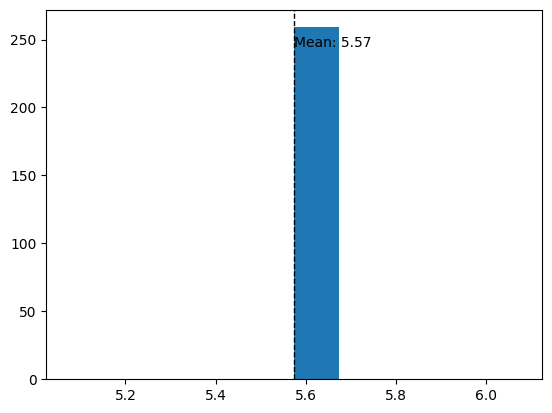

In [180]:
plt.hist(all_aesthetic_scores[all_no_entities])
plt.axvline(all_aesthetic_scores[all_no_entities].mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(all_aesthetic_scores[all_no_entities].mean(),max_ylim*0.9, 'Mean: {:.2f}'.format(all_aesthetic_scores[all_no_entities].mean()))

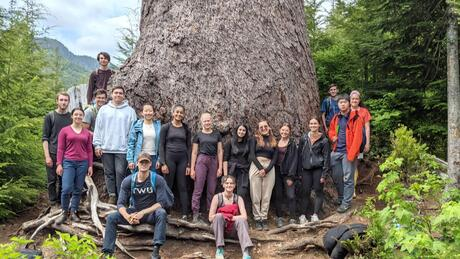

In [131]:
news_image_dataset[random_number]['image']

In [97]:
print(all_aesthetic_scores[random_number])

5.220431327819824
